# Supervised and Unsupervised learning example


We are going to try to be able to identify handwritten digits
These handwritten digits are contained in the MNIST data set.

You can download it from :  http://deeplearning.net/data/mnist/mnist.pkl.gz
And then unzip it

The script assumes the zipped data set has moved to the script's directory


In [1]:
# Let's import the relevant packages first
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import manifold
import gzip, cPickle
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics

## Part 1 : Load the data

In [2]:
# Unzip and load the data set
f = gzip.open("../data/mnist.pkl.gz", "rb")
train, val, test = cPickle.load(f)
f.close()

## Part 2 : Data exploration

Let's have a word on the data.

- train contains 2 arrays : a data and a target array
- The data is stored in train[0]
- The targets (= class of the digit) are stored in train[1]

In [3]:
train_data = train[0]
train_class = train[1]
print train_data.shape

(50000L, 784L)


It's a 50000 x 784 array :

- There are 50000 handwritten digits
- Each digit is stored in an array of dimension 784 = 28*28
- This array stores the grayscale value of a 28*28 picture of the digit.

Let's visualise the first digit.
#### N.B. : Close the figure to continue

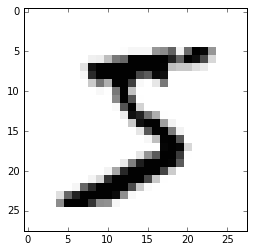

First digit class : 5


In [5]:
%matplotlib inline
first_digit = train_data[0]
# reshape the digit to a 28*28 array
first_digit = np.reshape(first_digit, (28,28))
# Then plot the digit
fig = plt.figure()
im = plt.imshow(first_digit, cmap = mpl.cm.Greys)
im.set_interpolation("nearest")
plt.show()
# We recognize a handwritten 5.
# let's look at the actual class of this digit
first_digit_class = train_class[0]
print "First digit class :", first_digit_class
# it's indeed a 5 !

**Likewise, eval and test contain handwritten digits and their class.**  
**We won't look at those for now.**

## Part 3 : pandas format

Now that we know the structure of the data, let's put it in a pandas dataframe. It will be easier to manipulate.

In [6]:
# Let's define a list of feature names
# We have 784 pixels, let's index them from 0 to 783
lfeat = ["p" + str(i) for i in range(784)]

# Build a dataframe with all features
df_mnist = pd.DataFrame(train_data, columns = lfeat)
# Add the target = digit class
df_mnist["Class"] = train_class
# Let's have a look at the first few rows
df_mnist.iloc[:5,:]

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p775,p776,p777,p778,p779,p780,p781,p782,p783,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Part 3 : First attempt at unsupervised classification

Let's see how far we can go with a simple unsupervised learning method  


We will use the **K-Means algorithm.**

The KMeans algorithm clusters data by trying to separate samples in n groups 
of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.  
This algorithm requires the number of clusters to be specified. 

- What KMeans finds are the location of centroids= the mean of each of the 10 groups of equal variances.
- Of course, we hope the algorithm has found 10 well separated  groups of points
- KMeans will classify using the following rule : a point will be associated to the nearest cluster (i.e. the group of points whose centroid is closest to this particular point).

**N.B.** 
Let's call i the index of this cluster.  
Of course, i is not equal to the class of the digit.  
It could very well be that all the 8 digits belong to cluster #3


In [7]:
# Initialise the kmeans method
# we use 10 clusters under the naive assumption of one cluster per class of digit
km = KMeans(n_clusters=10, n_jobs = -1, precompute_distances=True) 
#n_jobs = -1 to speed up with max # of CPU
#precompute_distances = True to speed up algorithm as well

#We'll take a subset of data, otherwise, it takes too much time
data_subset = df_mnist[lfeat].values[:2000]
class_subset = df_mnist["Class"].values[:2000]
#Let's examine the statistics of our subset
for i in range(10):
  print "%s samples of class %s" % (len(np.where(class_subset == i)[0]),i)
#Now fit
pred_km = km.fit_predict(data_subset)

191 samples of class 0
220 samples of class 1
198 samples of class 2
191 samples of class 3
214 samples of class 4
180 samples of class 5
200 samples of class 6
224 samples of class 7
172 samples of class 8
210 samples of class 9


## Part 4 : Measuring the performance 

Now we will evaluate the performance of the algorithm.
If we have the ground truth labels (i.e. we know to which class each training sample belongs), we can define the classification performance with metrics that measure the similarity between label assignments.

In our problem, this means that we compare the cluster assignment to the actual class of the digit, ignoring permutations. (cf. N.B. above, the cluster index may not be equal to the class index)

scikit-learn provides a range of such metrics.
We will report scores for three of them :
- [Adjusted Rand Index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index)
- [Mutual information](http://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores)
- [V-measure](http://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores)

All these scores span the [0,1] range, the higher, the better.

In [8]:
print "Rand score:", metrics.adjusted_rand_score(class_subset, pred_km)
print "MI:", metrics.adjusted_mutual_info_score(class_subset, pred_km)
print "V:",metrics.v_measure_score(class_subset, pred_km)   

Rand score: 0.318517477031
MI: 0.449970244914
V: 0.460236486711


## Part 4 : Improving unsupervised classification with tsne


### N.B. You should have sklearn version 0.17 or else tsne will be really slow

We are now going to apply t-sne to the data.
Its advantages are 2-fold

- It reduces the feature space (we project the 28*28 dimension feature space to a 2 dimension one) hence allowing easy visualisation
- It is sensitive to local structures and may provide much better separation between various classes than traditional methods such as PCA

**N.B.** This notebook cell may take time to execute

In [9]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, method = "barnes_hut")
data_subset_tsne = tsne.fit_transform(data_subset)
#Now let's apply kmeans to the transformed dataset
pred_km_tsne = km.fit_predict(data_subset_tsne)

print "Rand score:", metrics.adjusted_rand_score(class_subset, pred_km_tsne)
print "MI:", metrics.adjusted_mutual_info_score(class_subset, pred_km_tsne)
print "V:",metrics.v_measure_score(class_subset, pred_km_tsne)   


Rand score: 0.422685064629
MI: 0.542115200045
V: 0.547061888542


This new classification is a vast improvement over the previous one !
We are now going to do a visualisation of what has exactly happened :

- 2D plot of the data projected by tsne
- location of centroids in the data (how well our k-MEANS algorithm picks up the new structure in the data).
- We will see that while not perfects, the centroid detection works very well for some digits.

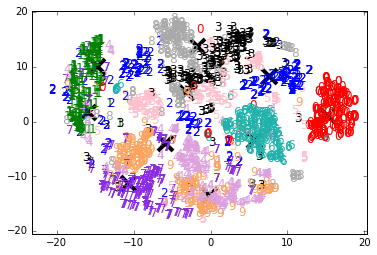

In [15]:
# color map, one color per digit
list_color = ["r", "g", "b", "k", "plum", "pink", "lightseagreen", "blueviolet", "darkgray", "sandybrown"]

# dictionnary of color to be used in the plot
d_color = {}
for i in range(10) :
    d_color[i] = list_color[i]
    
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the data
for i in range(2000):
    ax.text(data_subset_tsne[i,0], data_subset_tsne[i,1], str(class_subset[i]), color=d_color[class_subset[i]], fontsize=12)

# Also plot the cluster centers
for c in km.cluster_centers_ :
    ax.plot(c[0], c[1], "x", color = "k", markersize = 15, markeredgewidth=4)
    
# choose the boundaries of the plot for an ideal view
ax.set_xlim([-2 + min(data_subset_tsne[:,0]),2 + max(data_subset_tsne[:,0])])
ax.set_ylim([-2 + min(data_subset_tsne[:,1]),2 + max(data_subset_tsne[:,1])])
plt.show()